In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

Evaluation:
1. Evaluate on the pretrained models: download the pretrained model [here](https://drive.google.com/drive/folders/1G1GOA0FthtmOERJIJ0pALOSgXc6XOfoY) (credit: caiyuanhao)
2. Evaluate on the models retrained with Hyper-Skin data: 
3. Do step 1-2 for (RGB, VIS) data, and only step 2 for (MSI, NIR) data (reason, all pretrained model is based on input with in_channels = 3)
4. For all, compute the SSIM (for spatial evaluation) and SAM (for spectral evaluation)

In [2]:
import os 
import cv2 
import pickle
import spectral
import spectral.io.envi as envi
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torchvision import transforms
from torchmetrics import SpectralAngleMapper, StructuralSimilarityIndexMeasure

from hsiData import HyperSkinData
from utils import metrics 
from models.reconstruction import MST_Plus_Plus, HSCNN_Plus, hrnet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
data_dir = 'E:/hyper-skin-data'
rgbvis_dir = f'{data_dir}/Hyper-Skin(MSI, NIR)'
mask_dir = f'{data_dir}/mask'
pretrained_dir  = 'pretrained-models/hyper-skin/nir'

# directories to the test data 
msi_dir = f'{rgbvis_dir}/MSI/test'
nir_dir = f'{rgbvis_dir}/NIR/test'
mask_dir = f'{mask_dir}/test'

# directory to save the results
results_dir = 'E:/vis-nir-evaluation-results/pretrained-hyper-skin-nir'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [7]:
test_transform = transforms.Compose([
        transforms.ToTensor()
    ])
test_dataset = HyperSkinData.Load_v2(
            hsi_dir = nir_dir,
            rgb_dir = msi_dir, 
            transform = test_transform
    )
test_loader = torch.utils.data.DataLoader(
                                    dataset = test_dataset, 
                                    batch_size = 1, 
                                    shuffle = False,
                                    pin_memory = False)

1. Evaluation: MST_Plus_Plus (Pretrained on NTIRE)

In [9]:
# load the pretrained model from NTIRE 
model = MST_Plus_Plus.MST_Plus_Plus(in_channels=4, out_channels=31, n_feat=31, stage=3)
checkpoint = torch.load(f'{pretrained_dir}/mstpp')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [10]:
model.to(device)
model.eval() 
results = {
    "file": [],
    "pred": [],
    "ssim_score": [],
    "ssim_map": [],
    "sam_score": [],
    "sam_map": []
}
metrics.ssim_fn.to(device)
for k, data in enumerate(test_loader):
    x, y = data 
    x, y = x.float().to(device), y.float().to(device)

    with torch.no_grad():
        pred = model(x)

    ssim_score, ssim_map = metrics.ssim_fn(pred, y)
    sam_score, sam_map = metrics.sam_fn(pred, y)

    results["file"].append(test_dataset.rgb_files[0].split('\\')[-1].split('.')[0])
    results["pred"].append(pred.cpu().detach().numpy())
    results["ssim_score"].append(ssim_score.cpu().detach().numpy())
    results["ssim_map"].append(ssim_map.cpu().detach().numpy())
    results["sam_score"].append(sam_score.cpu().detach().numpy())
    results["sam_map"].append(sam_map.cpu().detach().numpy())
    
    print(f"Test [{k}/{len(test_loader)}]: {results['file'][-1]}, SSIM: {results['ssim_score'][-1]}, SAM: {results['sam_score'][-1]}")    

# save the results in pickle format
with open(f'{results_dir}/mst_plus_plus.pkl', 'wb') as f:
    pickle.dump(results, f)

Test [0/30]: p005_neutral_front, SSIM: 0.9595953226089478, SAM: 0.08729730546474457
Test [1/30]: p005_neutral_front, SSIM: 0.9489962458610535, SAM: 0.08187185227870941
Test [2/30]: p005_neutral_front, SSIM: 0.9472227096557617, SAM: 0.0946161225438118
Test [3/30]: p005_neutral_front, SSIM: 0.9573922753334045, SAM: 0.0880843847990036
Test [4/30]: p005_neutral_front, SSIM: 0.9450947642326355, SAM: 0.09446199238300323
Test [5/30]: p005_neutral_front, SSIM: 0.9555466771125793, SAM: 0.07548493891954422
Test [6/30]: p005_neutral_front, SSIM: 0.9573655128479004, SAM: 0.08238615095615387
Test [7/30]: p005_neutral_front, SSIM: 0.9614443778991699, SAM: 0.07513023912906647
Test [8/30]: p005_neutral_front, SSIM: 0.9576219320297241, SAM: 0.08647476136684418
Test [9/30]: p005_neutral_front, SSIM: 0.9566259384155273, SAM: 0.08238048851490021
Test [10/30]: p005_neutral_front, SSIM: 0.9593091607093811, SAM: 0.07427389919757843
Test [11/30]: p005_neutral_front, SSIM: 0.9552153944969177, SAM: 0.0875017568

In [11]:
# compute the mean and std of the SSIM and SAM scores
ssim_scores = np.array(results["ssim_score"])
ssim_mean = np.mean(ssim_scores)
ssim_std = np.std(ssim_scores)

sam_scores = np.array(results["sam_score"])
sam_mean = np.mean(sam_scores)
sam_std = np.std(sam_scores)
print(f"SSIM: {ssim_mean:.4f} +/- {ssim_std:.4f}")
print(f"SAM: {sam_mean:.4f} +/- {sam_std:.4f}")

SSIM: 0.9590 +/- 0.0056
SAM: 0.0862 +/- 0.0061


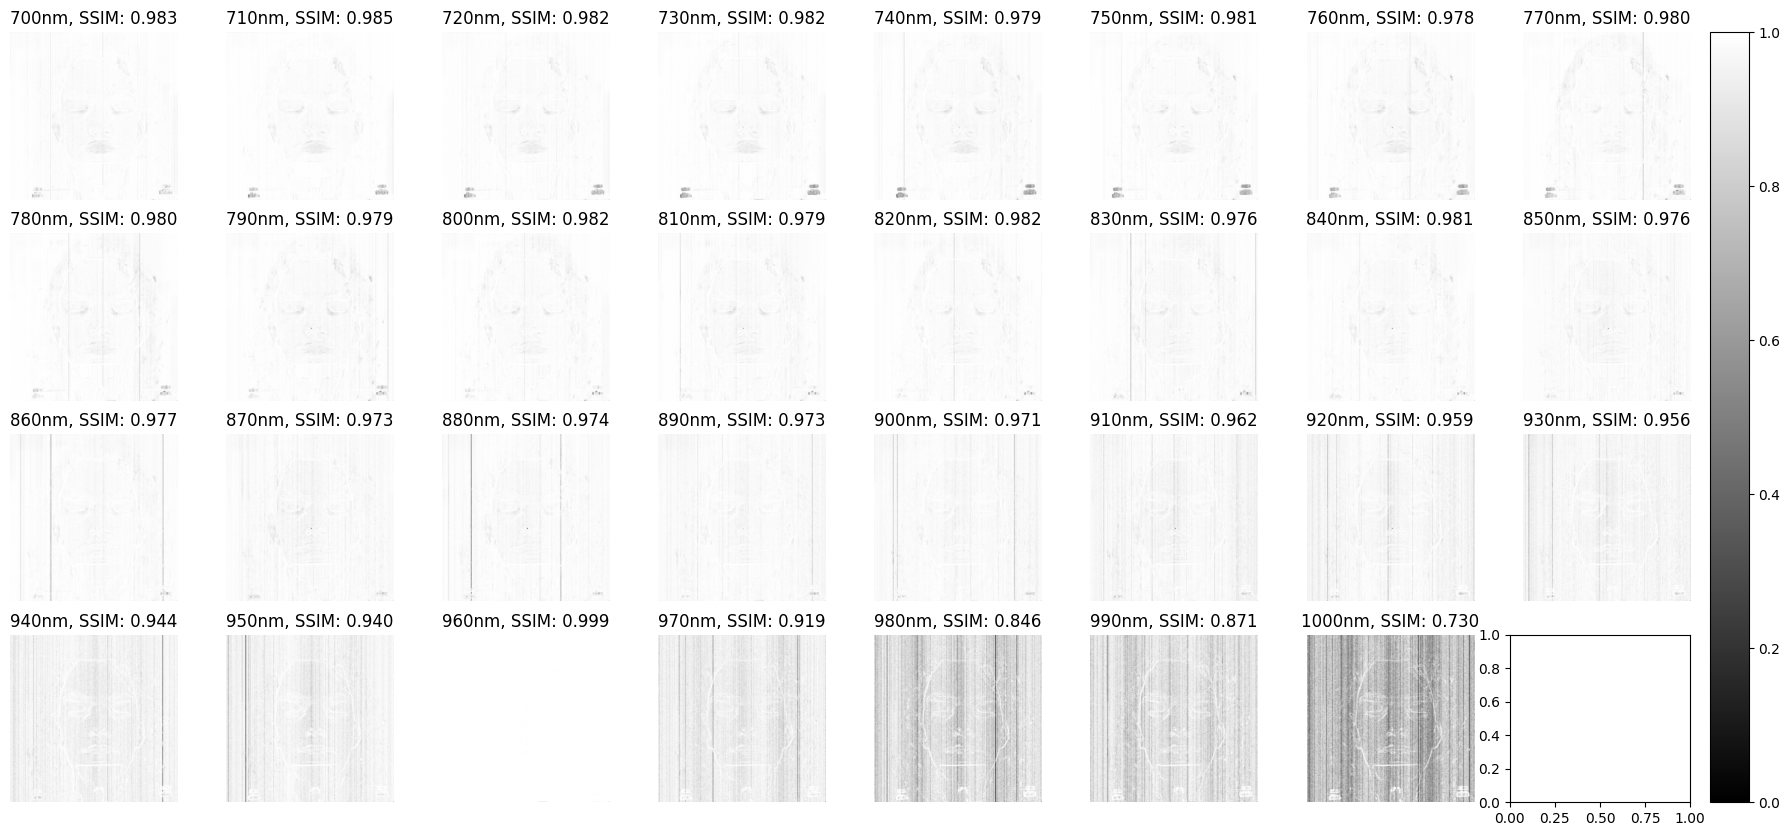

In [24]:
# visualize the ssim map for 31 bands to understand which band has better ssim score
band_31 = np.arange(700, 1010, 10)
ssim_map = np.array(results["ssim_map"]).squeeze()
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(26, 10))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(ssim_map[6, i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{band_31[i]}nm, SSIM: {ssim_map[6, i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()

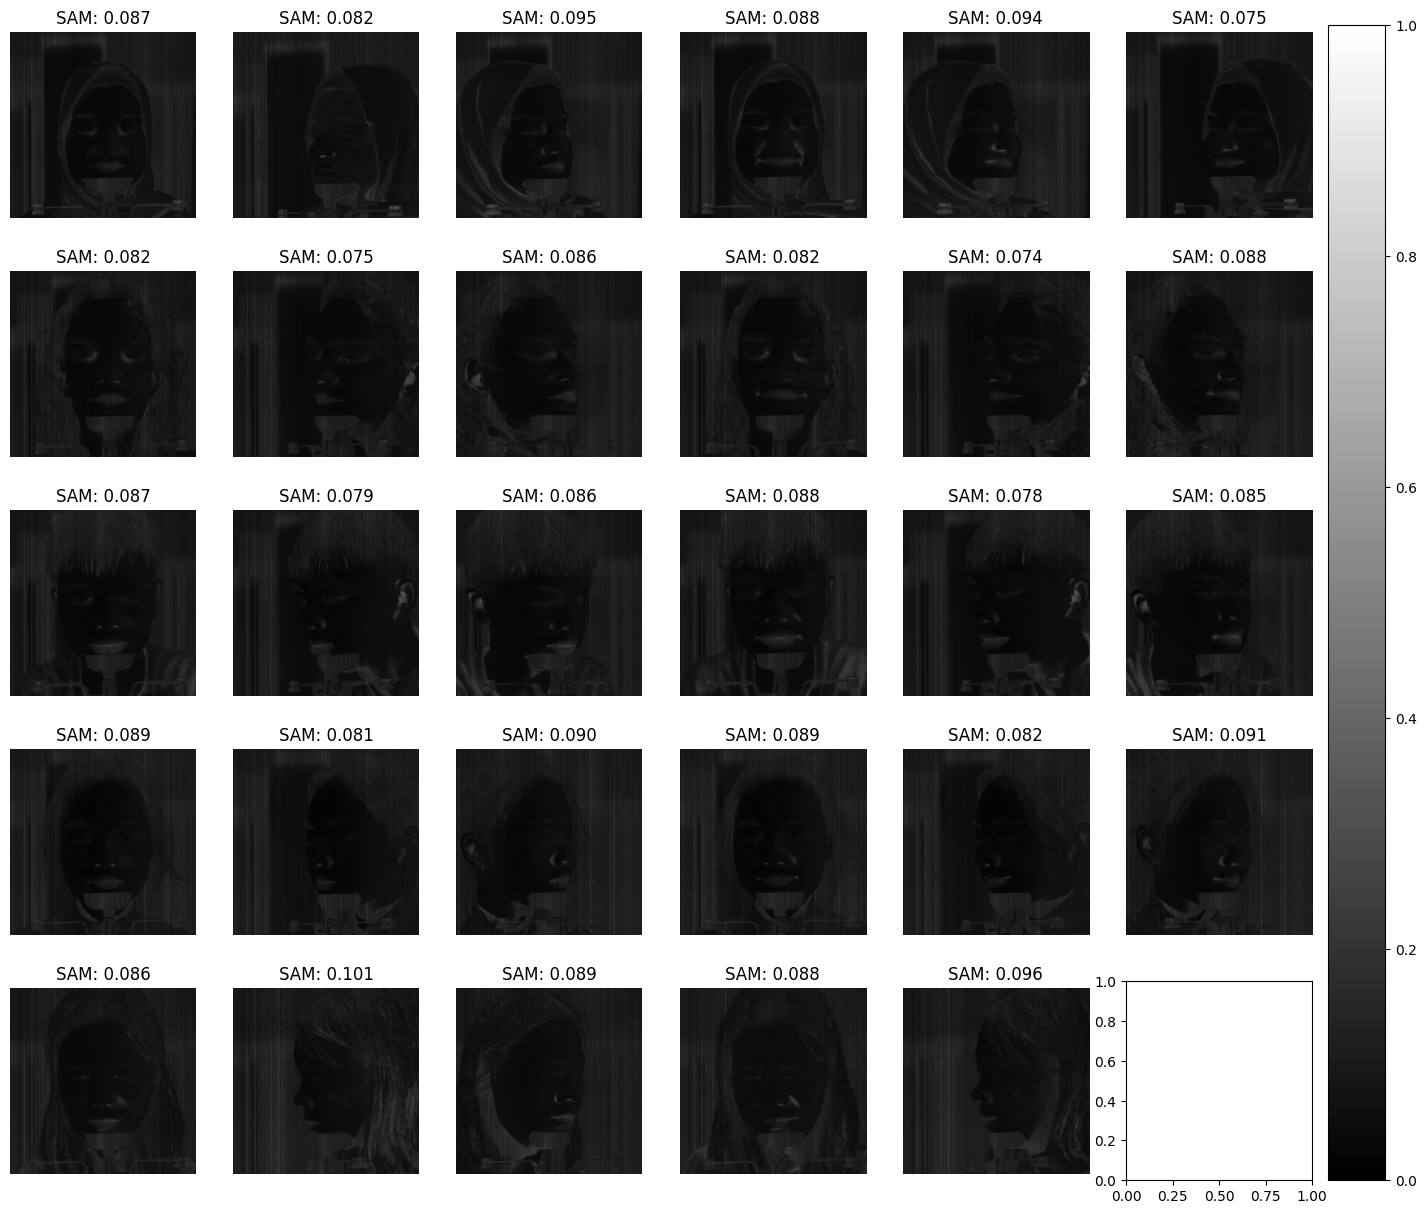

(30, 1024, 1024)

In [25]:
# visualize the sam map for 31 bands to understand which band has better ssim score
sam_map = np.array(results["sam_map"]).squeeze()
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(sam_map[i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"SAM: {sam_map[i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()
sam_map.shape

In [26]:
h, w, hwsize = 250, 500, 100
x, y = test_dataset[6]
y = y.numpy()
p = np.array(results["pred"]).squeeze()[6]

yy = y[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
yy_median = np.median(yy, axis=1)
yy_max = yy.max(1)
yy_min = yy.min(1)
pp = p[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
pp_median = np.median(pp, axis=1)
pp_max = pp.max(1)
pp_min = pp.min(1)

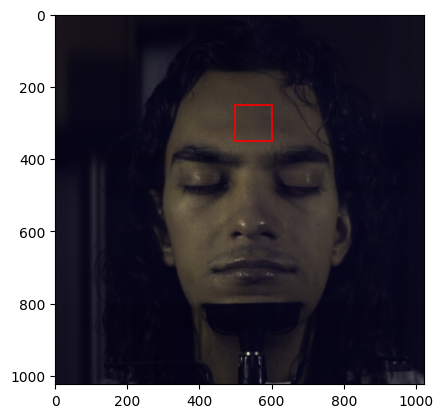

In [268]:
plt.imshow(x.permute(1, 2, 0).numpy())

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((w,h),hwsize,hwsize,linewidth=1.2,edgecolor='r',facecolor='none'))

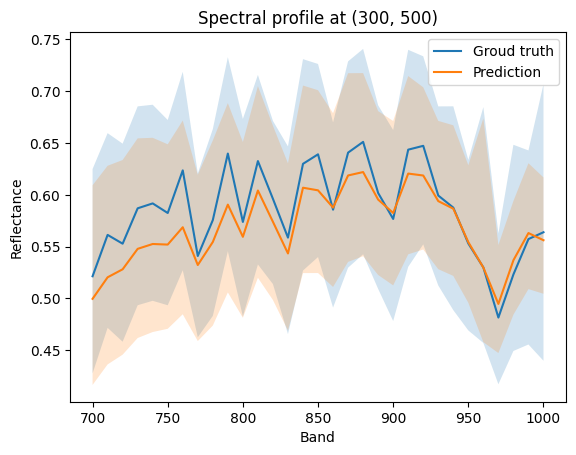

In [27]:
plt.plot(band_31, yy_median, label='Groud truth')
plt.fill_between(band_31, yy_min, yy_max, alpha=0.2)
plt.plot(band_31, pp_median, label='Prediction')
plt.fill_between(band_31, pp_min, pp_max, alpha=0.2)
plt.title('Spectral profile at (300, 500)')
plt.legend()
plt.ylabel('Reflectance')
plt.xlabel('Band')
plt.show()

1. only evaluate on the human subject - discard the background

In [16]:
model.to(device)
model.eval() 
results_m = {
    "file": [],
    "pred": [],
    "ssim_score": [],
    "ssim_map": [],
    "sam_score": [],
    "sam_map": []
}
masks = sorted(os.listdir(mask_dir))
for k, data in enumerate(test_loader):
    x, y = data 
    x, y = x.float().to(device), y.float().to(device)

    mask = plt.imread(f"{mask_dir}/{masks[k]}")/255
    mask = torch.from_numpy(mask[:,:,0]).float().to(device)

    with torch.no_grad():
        pred = model(x)
        pred = pred * mask[None, None, ...]
        y = y * mask[None, None, ...]

    ssim_score, ssim_map = metrics.ssim_fn.to(device)(pred, y)
    sam_score, sam_map = metrics.sam_fn(pred, y)

    results_m["file"].append(test_dataset.rgb_files[0].split('\\')[-1].split('.')[0])
    results_m["pred"].append(pred.cpu().detach().numpy())
    results_m["ssim_score"].append(ssim_score.cpu().detach().numpy())
    results_m["ssim_map"].append(ssim_map.cpu().detach().numpy())
    results_m["sam_score"].append(sam_score.cpu().detach().numpy())
    results_m["sam_map"].append(sam_map.cpu().detach().numpy())
    
    print(f"Test [{k}/{len(test_loader)}]: {results_m['file'][-1]}, SSIM: {results_m['ssim_score'][-1]}, SAM: {results_m['sam_score'][-1]}")    

# save the results in pickle format
with open(f'{results_dir}/masked_mst_plus_plus.pkl', 'wb') as f:
    pickle.dump(results_m, f)

Test [0/30]: p005_neutral_front, SSIM: 0.9786630868911743, SAM: 0.07251673191785812
Test [1/30]: p005_neutral_front, SSIM: 0.9702880382537842, SAM: 0.0745377242565155
Test [2/30]: p005_neutral_front, SSIM: 0.9690873026847839, SAM: 0.08276325464248657
Test [3/30]: p005_neutral_front, SSIM: 0.9778063893318176, SAM: 0.07393120229244232
Test [4/30]: p005_neutral_front, SSIM: 0.9673616886138916, SAM: 0.081599660217762
Test [5/30]: p005_neutral_front, SSIM: 0.9751082062721252, SAM: 0.06960152089595795
Test [6/30]: p005_neutral_front, SSIM: 0.9735615253448486, SAM: 0.07392840832471848
Test [7/30]: p005_neutral_front, SSIM: 0.976614773273468, SAM: 0.06960463523864746
Test [8/30]: p005_neutral_front, SSIM: 0.9731307625770569, SAM: 0.0758800208568573
Test [9/30]: p005_neutral_front, SSIM: 0.9744790196418762, SAM: 0.07110046595335007
Test [10/30]: p005_neutral_front, SSIM: 0.9773120284080505, SAM: 0.06868312507867813
Test [11/30]: p005_neutral_front, SSIM: 0.9726115465164185, SAM: 0.0761686563491

In [17]:
# compute the mean and std of the SSIM and SAM scores
ssim_scores = np.array(results_m["ssim_score"])
ssim_mean = np.mean(ssim_scores)
ssim_std = np.std(ssim_scores)

sam_scores = np.array(results_m["sam_score"])
sam_mean = np.mean(sam_scores)
sam_std = np.std(sam_scores)
print(f"SSIM: {ssim_mean:.4f} +/- {ssim_std:.4f}")
print(f"SAM: {sam_mean:.4f} +/- {sam_std:.4f}")

SSIM: 0.9739 +/- 0.0036
SAM: 0.0763 +/- 0.0051


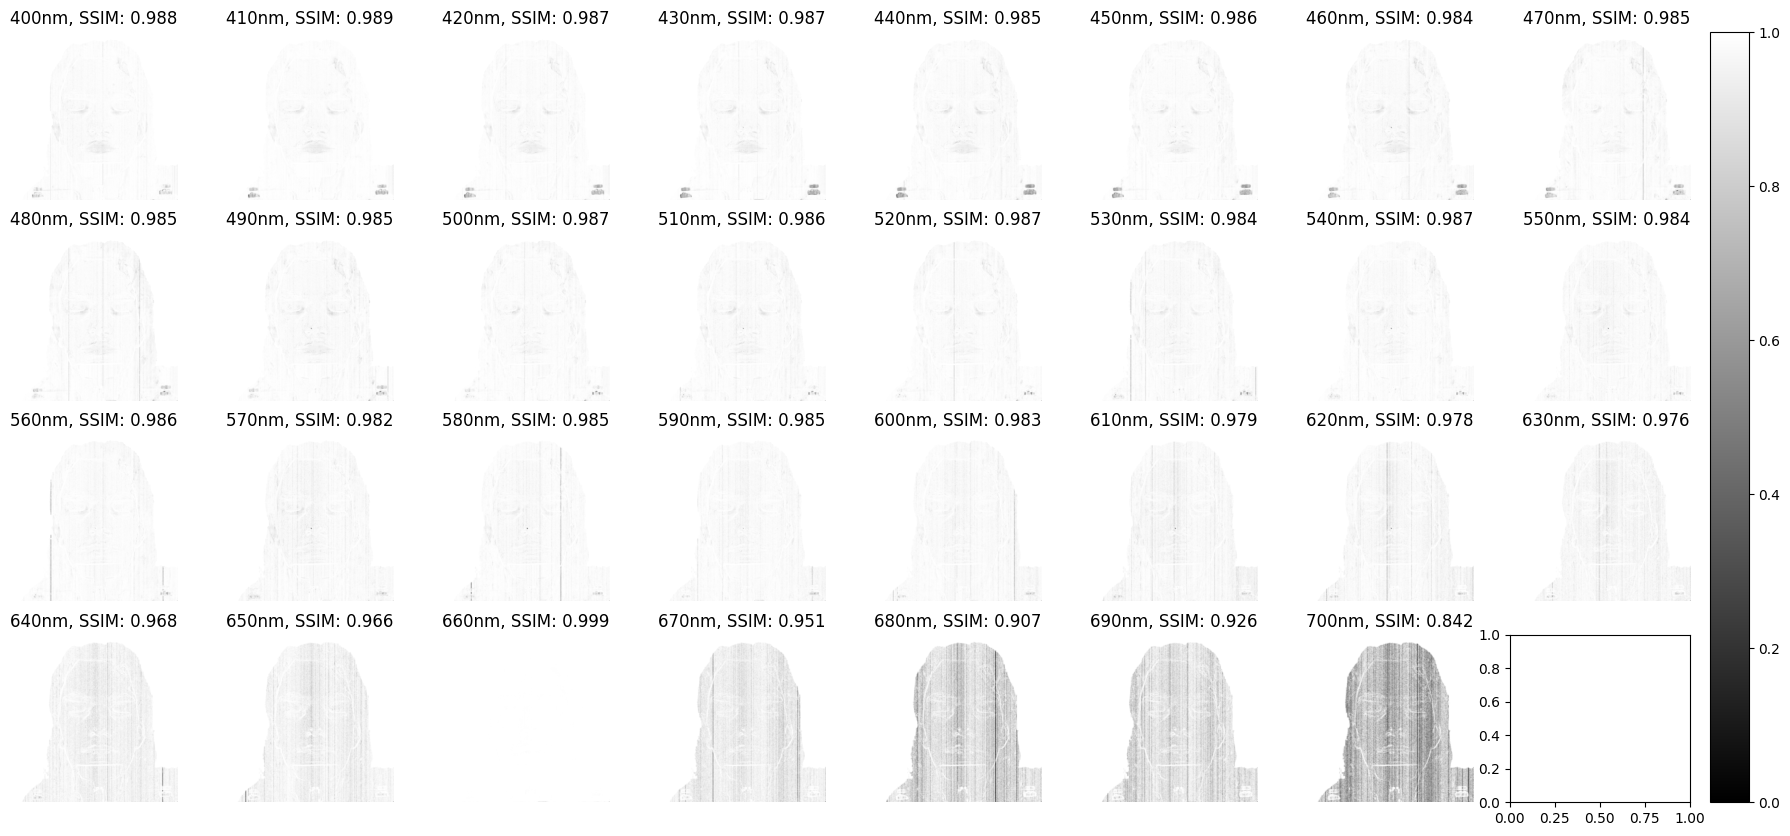

In [28]:
# visualize the ssim map for 31 bands to understand which band has better ssim score
band_31 = np.arange(400, 710, 10)
ssim_map = np.array(results_m["ssim_map"]).squeeze()
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(26, 10))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(ssim_map[6, i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{band_31[i]}nm, SSIM: {ssim_map[6, i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()

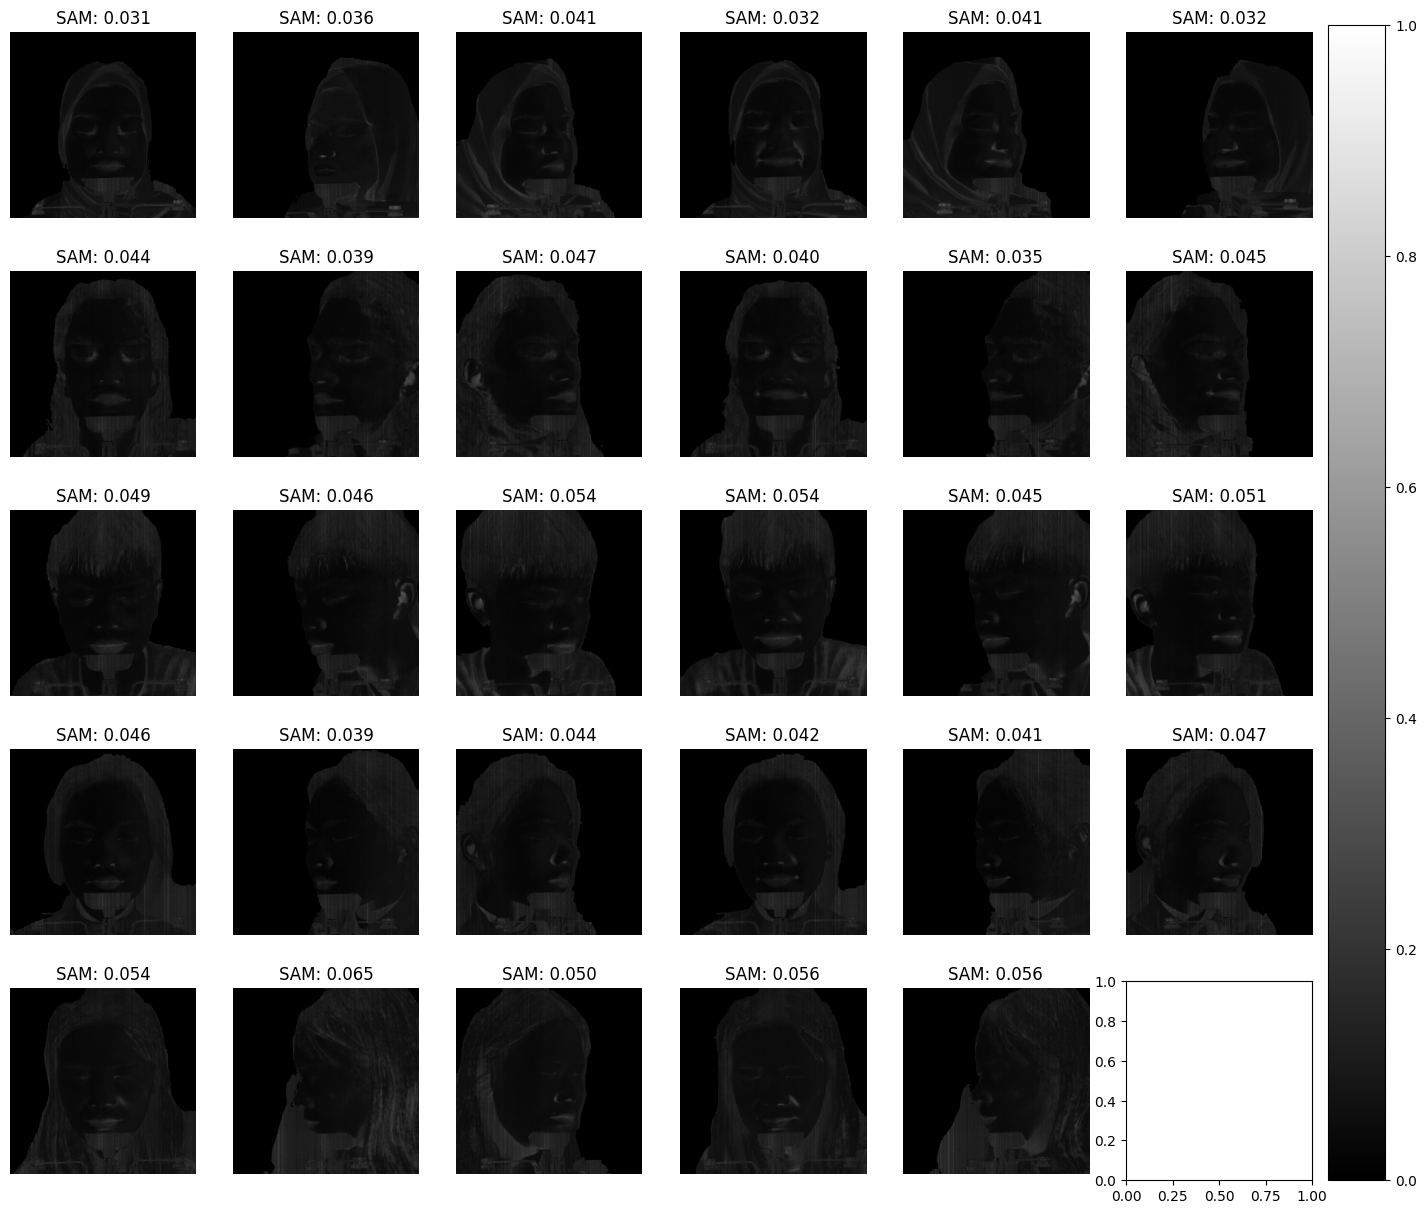

(30, 1024, 1024)

In [29]:
# visualize the sam map for 31 bands to understand which band has better ssim score
sam_map = np.array(results_m["sam_map"]).squeeze()
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(sam_map[i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"SAM: {sam_map[i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()
sam_map.shape

In [30]:
h, w, hwsize = 250, 500, 100
x, y = test_dataset[6]
y = y.numpy()
p = np.array(results_m["pred"]).squeeze()[6]

yy = y[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
yy_median = np.median(yy, axis=1)
yy_max = yy.max(1)
yy_min = yy.min(1)
pp = p[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
pp_median = np.median(pp, axis=1)
pp_max = pp.max(1)
pp_min = pp.min(1)

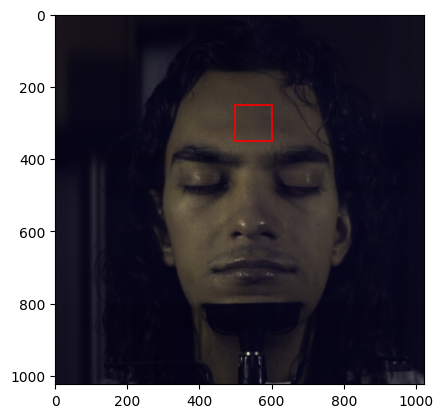

In [23]:
plt.imshow(x.permute(1, 2, 0).numpy())

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((w,h),hwsize,hwsize,linewidth=1.2,edgecolor='r',facecolor='none'))

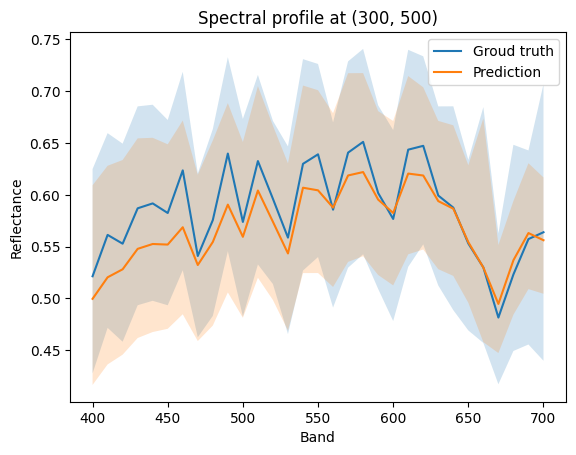

In [31]:
plt.plot(band_31, yy_median, label='Groud truth')
plt.fill_between(band_31, yy_min, yy_max, alpha=0.2)
plt.plot(band_31, pp_median, label='Prediction')
plt.fill_between(band_31, pp_min, pp_max, alpha=0.2)
plt.title('Spectral profile at (300, 500)')
plt.legend()
plt.ylabel('Reflectance')
plt.xlabel('Band')
plt.show()